SMOTE oversampling completed in 0.16 seconds.
Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
RandomizedSearchCV completed in 1184.33 seconds.
Model saved to random_forest_humanitarian_model.joblib
Accuracy: 0.9551681195516812
Precision (weighted): 0.9571780170562135
Recall (weighted): 0.9551681195516812
F1 Score (weighted): 0.933266175409095
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       767
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1

    accuracy                           0.96       803
   macro avg       0.16      0.17      0.16       803
weighted avg       0.91      0.96      0.93       803



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


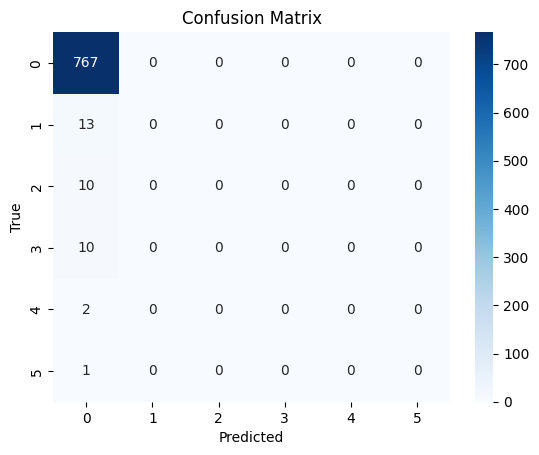

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
import joblib
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
import time

# Path to the CSV file
file_path = '/content/Hurricane_irma_original.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load and preprocess data
data = pd.read_csv(file_path)
if 'processed_data' not in data.columns or 'Humanitarian_Class' not in data.columns:
    raise KeyError("The dataset must contain 'processed_data' and 'Humanitarian_Class' columns.")

# Fill missing values and preprocess
data['processed_data'] = data['processed_data'].fillna('').astype(str)
data['Humanitarian_Class'] = data['Humanitarian_Class'].astype(str)

# Encode classes as integers
class_mapping = {label: idx for idx, label in enumerate(data['Humanitarian_Class'].unique())}
data['Humanitarian_Class'] = data['Humanitarian_Class'].map(class_mapping)

# Filter out classes with less than 2 instances
class_counts = data['Humanitarian_Class'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_data = data[data['Humanitarian_Class'].isin(valid_classes)]

# Update sentences and labels
sentences = [sentence.split() for sentence in filtered_data['processed_data']]
labels = filtered_data['Humanitarian_Class'].values

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)

# Create embedding matrix
vocab_size = len(word2vec_model.wv.index_to_key)
embedding_dim = word2vec_model.vector_size
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

# Convert sentences to sequences of indices
X = [[word_index.get(word, 0) for word in sentence] for sentence in sentences]

# Aggregate embeddings using mean embedding
X = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(embedding_dim)], axis=0) for sentence in sentences])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

# Check the class distribution in the training data
unique_classes, class_counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    if count < 2:
        print(f"Class {cls} has fewer than 2 samples and will be skipped in SMOTE.")

# Reduce n_neighbors to 2 to handle small classes
smote = SMOTE(random_state=42, k_neighbors=2)  # Reduce k_neighbors to 2
start_time = time.time()
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f"SMOTE oversampling completed in {time.time() - start_time:.2f} seconds.")

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights_dict)

# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1, random_state=42)
start_time = time.time()
random_search.fit(X_train, y_train)
print(f"RandomizedSearchCV completed in {time.time() - start_time:.2f} seconds.")

# Best model
rf_model = random_search.best_estimator_

# Save the Random Forest model
model_path = 'random_forest_humanitarian_model.joblib'
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted', zero_division=1))
print("Recall (weighted):", recall_score(y_test, y_pred, average='weighted', zero_division=1))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted', zero_division=1))

# Classification report
print("Classification Report:")
# Use labels from y_test to match the class names properly
target_names = [str(label) for label in np.unique(y_train)]
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
